In [157]:
import itertools as it
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm

%matplotlib notebook

In [4]:
latent = np.load('../data/pendulum_v0_latent_kl2rl1-z6-b100.npz')['arr_0']

In [7]:
n_episodes, episode_len, state_size = latent.shape

In [9]:
details = pd.read_pickle('../data/pendulum_v0_details.pkl')

In [111]:
relevant_latent_vars = [2, 5]

In [12]:
details

,episode,image_index,pendulum_length,pendulum_mass,raw_action,raw_obs,reward,step
0,0,0,1.257675,1.396678,[0.0],"[-0.2934452649406187, 0.955975876517776, -0.28...",-3.499721,0
1,0,1,1.257675,1.396678,[0.4110535],"[-0.3162528337380962, 0.9486749417754345, 0.47...",-3.604943,1
2,0,2,1.257675,1.396678,[0.17953274],"[-0.37302253140839425, 0.9278222842019228, 1.2...",-3.960829,2
3,0,3,1.257675,1.396678,[-0.3053808],"[-0.4581436152391949, 0.8888781850262502, 1.87...",-4.539828,3
4,0,4,1.257675,1.396678,[0.58357644],"[-0.5695952580252172, 0.8219253263132766, 2.60...",-5.415962,4
5,0,5,1.257675,1.396678,[-0.24965115],"[-0.6929716263338626, 0.7209648570465842, 3.19...",-6.477573,5
6,0,6,1.257675,1.396678,[1.5670921],"[-0.8195603330449615, 0.572992897424769, 3.900...",-7.932276,6
7,0,7,1.257675,1.396678,[1.8546511],"[-0.9272986273046441, 0.37432239553481556, 4.5...",-9.661456,7
8,0,8,1.257675,1.396678,[-0.46623394],"[-0.9894124500982655, 0.14513098769920701, 4.7...",-11.242069,8
9,0,9,1.257675,1.396678,[1.1669002],"[-0.9945881751644238, -0.10389591822156204, 4....",-11.722407,9


In [141]:
def make_simple_model(n_in, n_hidden, n_out):
    return nn.Sequential(nn.Linear(n_in, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_out))

In [153]:
def make_2h_model(n_in, n_h1, n_h2, n_out):
    return nn.Sequential(nn.Linear(n_in, n_h1), nn.ReLU(), nn.Linear(n_h1, n_h2), nn.ReLU(), nn.Linear(n_h2, n_out))

In [163]:
def train(model, X, Y, seed=0, n_epochs=20):
    np.random.seed(seed)
    batch_size = 32
    arrs = sklearn.model_selection.train_test_split(X, Y, test_size=0.1)
    tensors = [torch.from_numpy(arr.astype(np.float32)) for arr in arrs]
    for tensor in tensors:
        tensor.requires_gradient = False
    X_train, X_test, Y_train, Y_test = tensors
    n_pts = X_train.shape[0]
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    n_batches = int(math.ceil(n_pts / batch_size))
    train_losses = np.zeros((2, n_epochs, n_batches))  # 0: torch losses, 1: correct losses
    validation_losses = np.zeros(n_epochs)
    for epoch in tqdm(range(n_epochs)):
        permute = np.random.permutation(n_pts)
        X_train, Y_train = X_train[permute], Y_train[permute]
        for batch in range(n_batches):
            idx_lb = batch_size * batch
            idx_ub = batch_size * (batch + 1)
            X_batch, Y_batch = X_train[idx_lb:idx_ub], Y_train[idx_lb:idx_ub]
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            train_losses[0, epoch, batch] = loss.item()
            train_losses[1, epoch, batch] = torch.mean((Y_pred - Y_batch) ** 2).item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # compute validation loss
        with torch.no_grad():
            Y_test_pred = model.forward(X_test)
            validation_losses[epoch] = torch.mean((Y_test_pred - Y_test) ** 2).item()
        print(f"Epoch {epoch} Train loss: {train_losses[1, epoch].mean()}, Validation loss: {validation_losses[epoch]}")
    return validation_losses

In [94]:
def make_l2l_data():
    actions = np.array(details[details['step'] > 0]['raw_action'].tolist())
    filtered_size = len(relevant_latent_vars)
    filtered_latent = latent[:, :, relevant_latent_vars]
    latent_in = filtered_latent[:, :-1, :].reshape(-1, filtered_size)
    X = np.concatenate([latent_in, actions], axis=1)
    Y = filtered_latent[:, 1:, :].reshape(-1, filtered_size)
    return X, Y

In [130]:
def make_l2r_data():
    Y = np.array(details['reward'].tolist())[:, None]
    filtered_size = len(relevant_latent_vars)
    X = latent[:, :, relevant_latent_vars].reshape(-1, filtered_size)
    return X, Y

In [126]:
def scale_data_l2l(X, Y):
    state_scaler = sklearn.preprocessing.StandardScaler(copy=False)
    state_scaler.fit(X[:, :2])
    action_scaler = sklearn.preprocessing.StandardScaler(copy=False)
    action_scaler.fit(X[:, [2]])
    state_scaler.transform(X[:, :2])
    state_scaler.transform(Y)
    action_scaler.transform(X[:, [2]])
    return state_scaler, action_scaler

In [132]:
def scale_data_l2r(X, Y):
    state_scaler = sklearn.preprocessing.StandardScaler(copy=False)
    state_scaler.fit(X)
    reward_scaler = sklearn.preprocessing.StandardScaler(copy=False)
    reward_scaler.fit(Y)
    state_scaler.transform(X)
    reward_scaler.transform(Y)
    return state_scaler, reward_scaler

# L2L

In [122]:
X_l2l, Y_l2l = make_l2l_data()
z_scaler, a_scaler = scale_data_l2l(X_l2l, Y_l2l)

In [80]:
model10_l2l = make_simple_model(10)

In [106]:
model10.z_scaler = z_scaler
model10.a_scaler = a_scaler

In [81]:
losses = train(model10)

Epoch 0 Train loss: 0.6124065946509589, Validation loss: 0.2806953489780426
Epoch 1 Train loss: 0.13706394796496008, Validation loss: 0.0656227096915245
Epoch 2 Train loss: 0.061893052821144906, Validation loss: 0.055522020906209946
Epoch 3 Train loss: 0.055068704681888, Validation loss: 0.051819879561662674
Epoch 4 Train loss: 0.05222600586573357, Validation loss: 0.04955441132187843
Epoch 5 Train loss: 0.05134741373276755, Validation loss: 0.04882894456386566
Epoch 6 Train loss: 0.05062776550636696, Validation loss: 0.048244278877973557
Epoch 7 Train loss: 0.050369464959115234, Validation loss: 0.04831942170858383
Epoch 8 Train loss: 0.04979297570856427, Validation loss: 0.04770434647798538
Epoch 9 Train loss: 0.04949351654947499, Validation loss: 0.04733553156256676
Epoch 10 Train loss: 0.04917375478587711, Validation loss: 0.04646744951605797
Epoch 11 Train loss: 0.048773972067370344, Validation loss: 0.04652942717075348
Epoch 12 Train loss: 0.04859761457278657, Validation loss: 0.

<IPython.core.display.Javascript object>


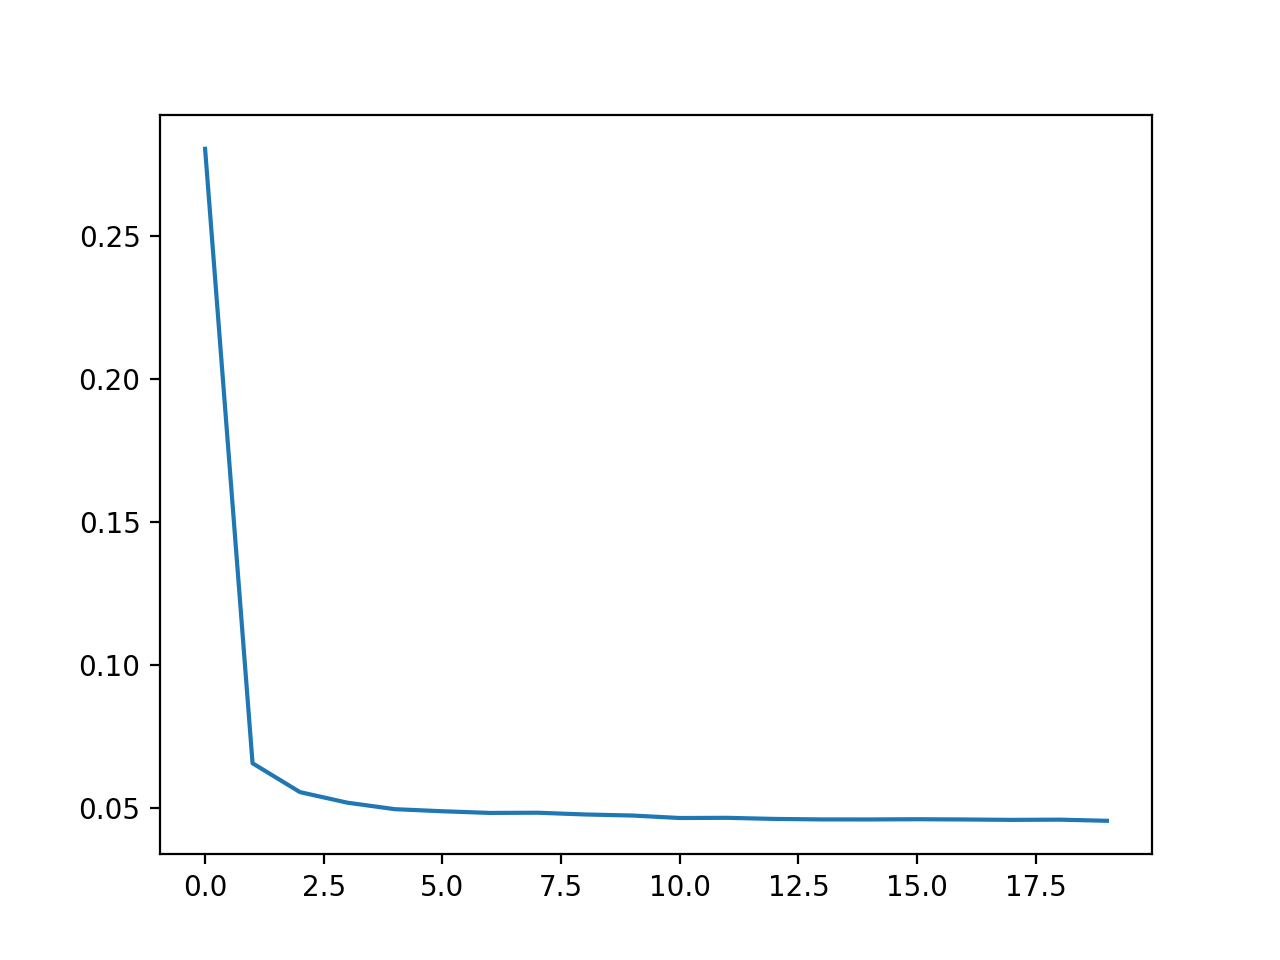

In [92]:
plt.figure()
plt.plot(np.arange(20), losses)
plt.show()

In [107]:
torch.save(model10, 'model10.pth')

# L2R

In [246]:
X_l2r, Y_l2r = make_l2r_data()
z_scaler, r_scaler = scale_data_l2r(X_l2r, Y_l2r)

In [181]:
model10_l2r = make_simple_model(2, 5, 1)
model10_l2r.r_scaler = r_scaler

In [152]:
train(model10_l2r, X_l2r, Y_l2r)

Epoch 0 Train loss: 0.5214149188382405, Validation loss: 0.34824860095977783
Epoch 1 Train loss: 0.29345406177090416, Validation loss: 0.29228508472442627
Epoch 2 Train loss: 0.2801430191025666, Validation loss: 0.29023727774620056
Epoch 3 Train loss: 0.27766010952545395, Validation loss: 0.28661707043647766
Epoch 4 Train loss: 0.2745444552167088, Validation loss: 0.28228434920310974
Epoch 5 Train loss: 0.26981513651338873, Validation loss: 0.2756819427013397
Epoch 6 Train loss: 0.2617147829621396, Validation loss: 0.26719072461128235
Epoch 7 Train loss: 0.25004728167509355, Validation loss: 0.25419214367866516
Epoch 8 Train loss: 0.2392498752009784, Validation loss: 0.2441519796848297
Epoch 9 Train loss: 0.23092997528559772, Validation loss: 0.23681537806987762
Epoch 10 Train loss: 0.2238091826967314, Validation loss: 0.23093931376934052
Epoch 11 Train loss: 0.2199201414771114, Validation loss: 0.22516080737113953
Epoch 12 Train loss: 0.21413897231538245, Validation loss: 0.2236821800

array([0.3482486 , 0.29228508, 0.29023728, 0.28661707, 0.28228435,
       0.27568194, 0.26719072, 0.25419214, 0.24415198, 0.23681538,
       0.23093931, 0.22516081, 0.22368218, 0.22130361, 0.21834761,
       0.21835239, 0.21844175, 0.21680647, 0.21768221, 0.21656613])

In [264]:
model10_l2r = make_2h_model(2, 10, 10, 1)
model10_l2r.r_scaler = r_scaler

In [267]:
train(model10_l2r, X_l2r, Y_l2r)

Epoch 0 Train loss: 0.18416691397098786, Validation loss: 0.19766312837600708
Epoch 1 Train loss: 0.1837416725061464, Validation loss: 0.19592934846878052
Epoch 2 Train loss: 0.18358554825820822, Validation loss: 0.19665852189064026
Epoch 3 Train loss: 0.1834379861805033, Validation loss: 0.19899457693099976
Epoch 4 Train loss: 0.18306001990452303, Validation loss: 0.19637376070022583
Epoch 5 Train loss: 0.18347624816158983, Validation loss: 0.19652648270130157
Epoch 6 Train loss: 0.1832677254070204, Validation loss: 0.1994239091873169
Epoch 7 Train loss: 0.18303606717299062, Validation loss: 0.1965988129377365
Epoch 8 Train loss: 0.18324484093550672, Validation loss: 0.1969771385192871
Epoch 9 Train loss: 0.18362005892480518, Validation loss: 0.1954677551984787
Epoch 10 Train loss: 0.1827868160573726, Validation loss: 0.19574680924415588
Epoch 11 Train loss: 0.1832380824530801, Validation loss: 0.19447042047977448
Epoch 12 Train loss: 0.18236421808230538, Validation loss: 0.1958224475

array([0.19766313, 0.19592935, 0.19665852, 0.19899458, 0.19637376,
       0.19652648, 0.19942391, 0.19659881, 0.19697714, 0.19546776,
       0.19574681, 0.19447042, 0.19582245, 0.19832624, 0.19542554,
       0.1971568 , 0.19573575, 0.1961697 , 0.19763757, 0.19547361,
       0.19616044, 0.19861557, 0.19538707, 0.19507295, 0.19484273,
       0.19918139, 0.19591081, 0.19719428, 0.19815469, 0.19489096])

In [266]:
torch.save(model10_l2r, 'model10-10_l2r.pth')

In [247]:
X_obs = np.array(details['raw_obs'].tolist())
raw_actions = np.array(details['raw_action'].tolist())
#sklearn.preprocessing.StandardScaler(copy=False).fit_transform(X_obs)
#model_10_obs = make_simple_model(2, 10, 1)
#train(model_10_obs, X_obs, Y_l2r, n_epochs=100)

In [209]:
raw_actions

array([[ 0.        ],
       [ 0.4110535 ],
       [ 0.17953274],
       ...,
       [-1.5210258 ],
       [-0.9810532 ],
       [ 1.3136857 ]], dtype=float32)

<IPython.core.display.Javascript object>


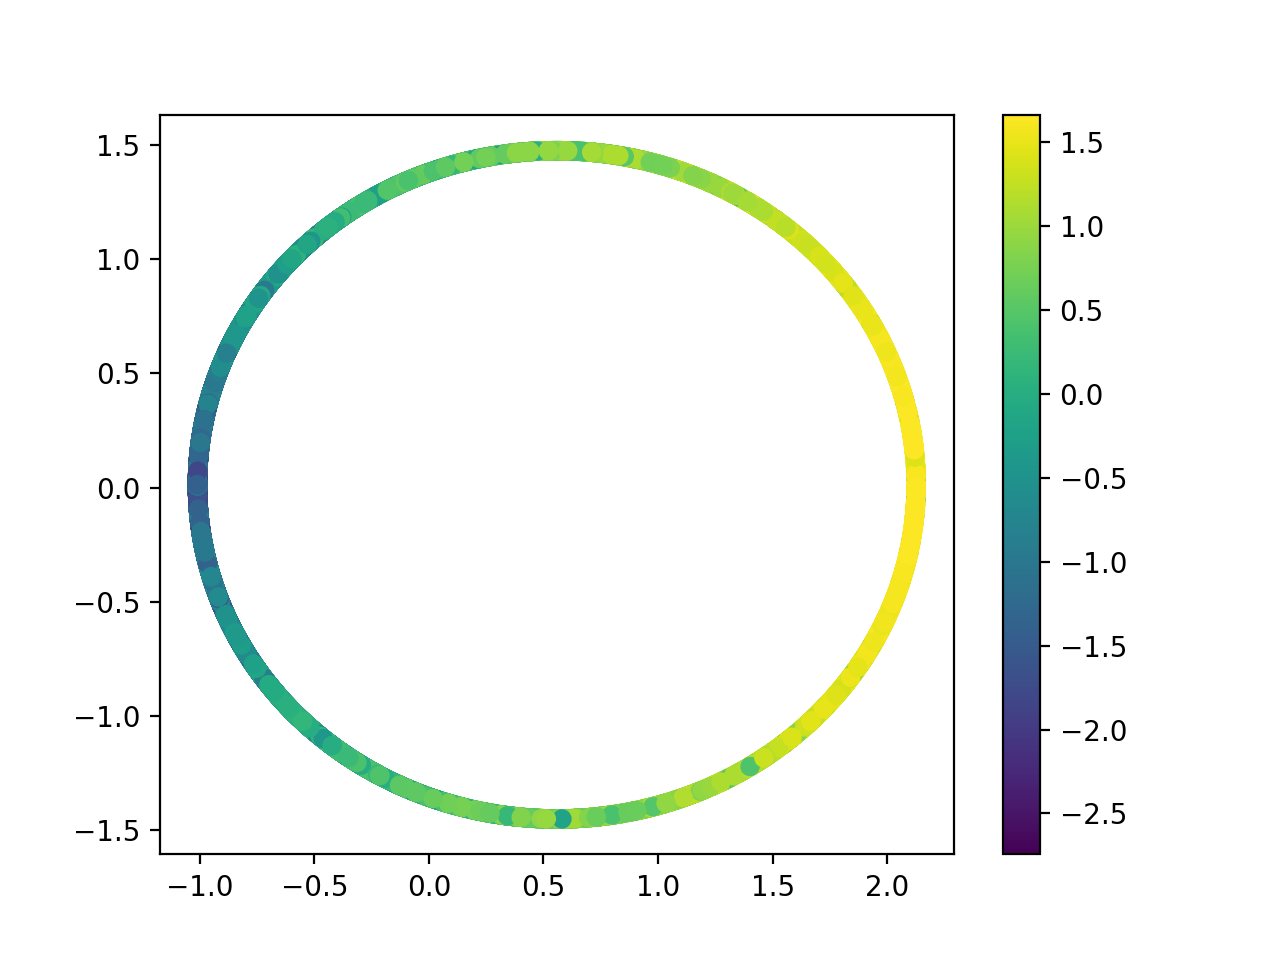

In [167]:
plt.figure()
plt.scatter(X_obs[:, 0], X_obs[:, 1], c=Y_l2r[:, 0])
plt.colorbar()
plt.show()

In [245]:
max_torque = 2

def angle_normalize(x):
    return np.fmod(x + np.pi, 2*np.pi) - np.pi

def foo_reward_fn(X, a, bias=0.0):
    x, y, v = X[:, 0], X[:, 1], X[:, 2]
    th = np.arctan2(y, x)
    costs = angle_normalize(th) ** 2 + bias #+ .1 * v ** 2 #+ .001 * (a ** 2)
    return -costs.ravel()

In [283]:
rewards_ = foo_reward_fn(X_obs, raw_actions.ravel())
scaled_rewards_ = r_scaler.transform(rewards_[:, None], copy=True)[:, 0]

scaled_true_rewards = Y_l2r.ravel()
true_rewards = r_scaler.inverse_transform(scaled_true_rewards, copy=True)

In [286]:
bias_rewards_ = foo_reward_fn(X_obs, raw_actions.ravel(), bias=1.332683878500003)
scaled_bias_rewards_ = r_scaler.transform(bias_rewards_[:, None], copy=True)[:, 0]

In [285]:
(rewards_ - true_rewards).mean()

1.3326838785000066

In [288]:
np.mean((scaled_bias_rewards_ - scaled_true_rewards) ** 2)

0.19521302447770963